In [1]:
import time
start_simulation = time.time()

import os

import numpy as np
import scipy as sc

import bsplines  as bsp

import HyCho_FEM as fem
import HyCho_PIC as pic

import matplotlib.pyplot as plt

from scipy.sparse.linalg import splu
from scipy.sparse        import block_diag
from scipy.sparse.linalg import inv

import scipy.special as sp
import sobol_seq     as sobol


#=========================== time integration =======================================
time_integr = False                 # do time integration? (1 : yes, 0: no)

# name of output file
#identifier  = 'run_L=327.7_Nel=3200_T=5000_dt=0.02_Np=1.5e7_nuh=6e-3_xi=8.62e-5_bc=False_k=no_p=3_CV=off_amp=no_rel=on_wperp=0.55_1'  
identifier  = 'test'

dir_results = 'results/'            # directory of where to save output file
max_time           = 23.5*60        # maximum runtime of program in minutes
time_restart_files = 120*60         # time interval for restart files in minutes
#====================================================================================



#===== Is this run a restart? (restart = 0: no, restart = 1: yes) ===================
restart        = False

# locate restart files
name_particles = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=particles1.npy'
name_fields    = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=fields1.npy'
name_time_step = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=time1.npy'
name_control   = 'restart_files/' + identifier + '_restart_files/' + identifier + '_restart=CV1.npy'

# create restart files at end of simulation?
create_restart = False
dir_restart    = '/home/florian/Desktop/Masterarbeit/06_Github/mhd/02_HybridModelling/restart_files/' + identifier + '_restart_files/'
#====================================================================================



#===== physical parameters ==========================================================
wpe   = 5.                         # cold electron plasma frequency
nuh   = 6e-3                       # ratio of cold/hot electron densities (nh/nc)
nh    = nuh*wpe**2                 # hot electron density
wpar  = 0.2                        # parallel thermal velocity of energetic particles
wperp = 0.55                       # perpendicular thermal velocity of energetic particles
xi    = 8.62e-5                    # inhomogeneity factor of background magnetic field

rel   = 1                          # relativistic fast electrons? (1: yes, 0: no)
bc_d  = 1                          # damping of E and j at boundaries? (1: yes, 0: no)
bc_f  = 1                          # field line dependence of initial distribution function? (1: yes, 0: no)
#===================================================================================



#===== numerical parameters =========================================================
bc      = False                    # boundary conditions (True: periodic, False: homogeneous Dirichlet)
k       = 2.                       # wavenumber of initial wave field perturbations
Lz      = 327.7                    # length of z-domain
Nel     = 3200                     # number of elements z-direction
T       = 200.                     # simulation time
dt      = 0.02                     # time step
p       = 3                        # degree of B-spline basis functions in V0
Np      = np.int(1.5e7)            # number of markers
control = 0                        # control variate for noise reduction? (1: yes, 0: no)
Ld      = 0.046*Lz                 # length of damping region at each end
loading = 'pseudo-random'          # particle loading: 
                                   # 1: 'pseudo-random'         --> np.random.rand(Np, 4)
                                   # 2: 'external loading'      --> numbers between (0, 1) from an external file (shape(Np, 5))
                                   # 3: 'sobol_plain'           --> sobol.i4_sobol_generate(4, Np, skip=1000)
                                   # 4: 'sobol_antithetic16'    --> sobol.i4_sobol_generate(4, int(Np/16), skip=1000)
                                   # 5: 'pr_space_uni_velocity' --> pseudo-random in space, uniform in velocity space
                                   # 6: 'importance sampling'
                                   
                
# name of particle file for external loading                            
name_initial_particles = 'test_particles_Np=1.3e7_1.npy' 
#====================================================================================


#===== evaluation points for the magnetic field =====================================
eva_points_Bx = np.array([100., 120., 140., 160., 180., 200.])
#eva_points_Bx = np.array([np.pi/4, np.pi/2, 3*np.pi/4])
#eva_points_Bx = np.linspace(0., Lz, Nel + 1)
#====================================================================================


#===== initial conditions for fields ================================================
amp = 1e-4                         # amplitude of initial wave field perturbations

Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey

'''
def Bx0(z):
    
    value = 0.
    modes = 1 + np.arange(int(Nel/4))
    
    for i in range(int(Nel/4)):
        value += amp*np.random.rand()*np.sin(2*np.pi*modes[i]*z/Lz)
     
    return value
'''


Bx0 = lambda z : 0*z               # initial Bx
#Bx0 = lambda z : amp*np.sin(2*z) + amp*np.sin(1.5*z) 

By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0., Lz, Nel + 1)          # element boundaries

Nbase0     = Nel + p - bc*p                  # total number of basis functions in V0
Nbase0_dof = Nbase0 - 2 + 2*bc               # number of degrees of freedom in V1

Nbase1     = Nbase0 - 1 + bc                 # total number of basis functions in V1
Nbase1_dof = Nbase1                          # number of degrees of freedom in V1
#====================================================================================



#===== some diagnostic values =======================================================
nh       = nuh*wpe**2                                 # hot electron density
Eh_eq    = Lz*nh/2*(wpar**2 + 2*wperp**2)             # equilibrium energetic electron energy

energies = np.empty(4, dtype=float)                   # energies: E, B, cold, hot

Bx       = np.empty(len(eva_points_Bx), dtype=float)  # x-component of magnetic field at some positions
#====================================================================================


#===== background field in z-direction ==============================================
B_background_z = lambda z : 1. + xi*(z - Lz/2)**2
#====================================================================================


#===== initial energetic electron distribution function =============================
def fh0(z, vx, vy, vz):

    xiB = 1. - 1/B_background_z(z)
    xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f

    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== Maxwellian for control variate ===============================================
def maxwell(z, vx, vy, vz):
    
    xiB = 1. - 1/B_background_z(z)
    xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f
    
    return nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
def g_sampling(z, vx, vy, vz):
    
    if loading == 'importance sampling':
    
        xiB = 1. - 1/B_background_z(z)
        xiz = 1. + (wperp**2/wpar**2 - 1.)*xiB*bc_f
        
        normalization = 1/(Ta + 1) + 2*Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
        
        return 1/((2*np.pi)**(3/2)*wpar*wperp**2*Lz*normalization)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
    
    else:    
        return 1/((2*np.pi)**(3/2)*wpar*wperp**2*Lz)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== masking function to damp wave fields near boundaries =========================
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1
#====================================================================================



#===== spline knot vector, global mass matrices (in V0 and V1) and gradient matrix ==
T0 = bsp.make_knots(el_b, p, bc)
T1 = T0[1:-1]

M0 = fem.mass_V0(T0, p, bc)
M1 = fem.mass_V1(T0, p, bc)
MB = fem.mass_V0_B(T0, p, bc, B_background_z)

G  = sc.sparse.csc_matrix(fem.GRAD(T0, p, bc))

if bc == False:
    M0 = M0[1:-1, 1:-1]
    MB = MB[1:-1, 1:-1]
    
    G  = G[:, 1:-1]

    
D = sc.sparse.csr_matrix(bsp.collocation_matrix(T1, p - 1, eva_points_Bx, bc, normalize=True))
print('matrix assembly done!')
#====================================================================================



#=================== coefficients for pp-forms ======================================
if p == 3:
    pp_0 = np.asfortranarray([[1/6, -1/(2*dz), 1/(2*dz**2), -1/(6*dz**3)], [2/3, 0., -1/dz**2, 1/(2*dz**3)], [1/6, 1/(2*dz), 1/(2*dz**2), -1/(2*dz**3)], [0., 0., 0., 1/(6*dz**3)]])
    pp_1 = np.asfortranarray([[1/2, -1/dz, 1/(2*dz**2)], [1/2, 1/dz, -1/dz**2], [0., 0., 1/(2*dz**2)]])/dz
elif p == 2:
    pp_0 = np.asfortranarray([[1/2, -1/dz, 1/(2*dz**2)], [1/2, 1/dz, -1/dz**2], [0., 0., 1/(2*dz**2)]])
    pp_1 = np.asfortranarray([[1., -1/dz], [0., 1/dz]])/dz
else:
    print('Only cubic and quadratic splines implemented!')
#====================================================================================



#===== reserve memory for unknowns ==================================================
ex     = np.empty(Nbase0, dtype=float)
ey     = np.empty(Nbase0, dtype=float)
bx     = np.empty(Nbase1, dtype=float)
by     = np.empty(Nbase1, dtype=float)
yx     = np.empty(Nbase0, dtype=float)
yy     = np.empty(Nbase0, dtype=float)

uj     = np.empty(4*Nbase0_dof + 2*Nbase1_dof, dtype=float)
z_old  = np.empty(Np, dtype=float)
spans0 = np.empty(Np, dtype=int)

jh_x   = np.empty(Nbase0, dtype=float)
jh_y   = np.empty(Nbase0, dtype=float)

Fh     = np.zeros(4*Nbase0_dof + 2*Nbase1_dof, dtype=float)
#====================================================================================



#===== initial coefficients with commuting projectors ===============================
proj = fem.projectors_1d(T0, p, bc)

ex[:] = proj.PI_0(Ex0)
ey[:] = proj.PI_0(Ey0)
bx[:] = proj.PI_1(Bx0)
by[:] = proj.PI_1(By0)
yx[:] = proj.PI_0(jx0)
yy[:] = proj.PI_0(jy0)

if bc == False:
    uj[:] = np.concatenate((ex[1:-1], ey[1:-1], bx, by, yx[1:-1], yy[1:-1]))
    
else:
    uj[:] = np.concatenate((ex, ey, bx, by, yx, yy))

print('projection of initial fields done!')
#====================================================================================



#===== construct block matrices for field update ====================================
I  = sc.sparse.identity(Nbase1_dof)
A1 = sc.sparse.bmat([[M0, None, None, None, None, None],[None, M0, None, None, None, None], [None, None, I, None, None, None], [None, None, None, I, None, None], [None, None, None, None, M0, None], [None, None, None, None, None, M0]], format='csc')
A2 = sc.sparse.bmat([[None, None, None, G.T.dot(M1), -M0, None],[None, None, -G.T.dot(M1), None, None, -M0], [None, G, None, None, None, None], [-G, None, None, None, None, None], [wpe**2*M0, None, None, None, None, -MB], [None, wpe**2*M0, None, None, MB, None]], format='csc')

LHS = A1 - dt/2*A2
RHS = A1 + dt/2*A2

LU = sc.sparse.linalg.splu(LHS)
print('LU factorization done!')


if bc_d == 1:
    
    if bc == False:
        greville = bsp.greville(T0, p, bc)[1:-1]
        colloq = sc.sparse.csc_matrix(bsp.collocation_matrix(T0, p, greville, bc)[:, 1:-1])
    else:
        greville = bsp.greville(T0, p, bc)
        colloq = sc.sparse.csc_matrix(bsp.collocation_matrix(T0, p, greville, bc))
        
    g_greville = np.zeros(Nbase0_dof, dtype=float)
    
    for i in range(Nbase0_dof):
        g_greville[i] = damp(greville[i])
            
    G_greville = sc.sparse.diags(g_greville, 0)
    DAMP       = inv(colloq).dot(G_greville.dot(colloq))
             
else:
    DAMP = sc.sparse.identity(Nbase0_dof)
    
DAMP_block = sc.sparse.block_diag((DAMP, DAMP, sc.sparse.identity(Nbase1_dof), sc.sparse.identity(Nbase1_dof), DAMP, DAMP), format='csr')
print('damping assembly done!')
#====================================================================================


#===== create particles (z, vx, vy, vz, wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F', dtype=float)
    
if loading == 'pseudo-random':
    particles[:, :4] = np.random.rand(Np, 4)

    # inversion of cumulative distribution function 
    particles[:,  0] = particles[:, 0]*Lz
    particles[:,  1] = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:,  2] = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:,  3] = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)
    
elif loading == 'external loading':
    particles[:, :]  = np.load(name_initial_particles)

    # inversion of cumulative distribution function
    particles[:, 0]  = particles[:, 0]*Lz
    particles[:, 1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)
    
elif loading == 'sobol_plain':
    particles[:, :4] = sobol.i4_sobol_generate(4, Np, 1000)
    
    # inversion of cumulative distribution function
    particles[:,  0] = particles[:, 0]*Lz
    particles[:,  1] = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:,  2] = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:,  3] = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)
    
elif loading == 'sobol_antithetic16':
    pic.set_particles_symmetric(sobol.i4_sobol_generate(4, int(Np/16), 1000), particles)
    
    # inversion of cumulative distribution function
    particles[:,  0]  = particles[:, 0]*Lz
    particles[:,  1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:,  2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:,  3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)
    
elif loading == 'pr_space_uni_velocity':
    particles[:,  0]  = np.random.rand(Np)
    
    dv = 1/Np
    particles[:,  1]  = np.linspace(dv, 1 - dv, Np)
    particles[:,  2]  = np.linspace(dv, 1 - dv, Np)
    particles[:,  3]  = np.linspace(dv, 1 - dv, Np)
    
    # inversion of cumulative distribution function
    particles[:, 0] = particles[:, 0]*Lz
    particles[:, 1] = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2] = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3] = sp.erfinv(2*particles[:, 3] - 1)*wpar*np.sqrt(2)

elif loading == 'importance sampling':
    #particles[:, :4] = np.random.rand(Np, 4)
    #particles[:, :4] = sobol.i4_sobol_generate(4, Np, 1000)
    pic.set_particles_symmetric(sobol.i4_sobol_generate(4, int(Np/16), 1000), particles)
    
    Ta               = wperp**2/wpar**2 - 1.
    d_normalization  = 1/(Ta + 1) + 2*Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    d_constant       = Ta*np.arctan(np.sqrt(xi*(Ta + 1))*Lz/2)/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    
    Fz       = lambda U, z : U*d_normalization - z/(Lz*(Ta + 1)) - d_constant - Ta*np.arctan(np.sqrt(xi*(Ta + 1))*(z - Lz/2))/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))
    Fz_prime = lambda z    : -1/(Lz*(Ta + 1)) - Ta/(Lz*np.sqrt(xi)*(Ta + 1)**(3/2))*np.sqrt(xi*(Ta + 1))/(1 + xi*(Ta + 1)*(z - Lz/2)**2)
    
    # Newton method for particle position (inversion of cumulative distribution function)    
    for ip in range(Np):
    
        z_part = Lz/2
        U      = particles[ip, 0]

        while True:
            z_part = z_part - Fz(U, z_part)/Fz_prime(z_part)

            if np.abs(Fz(U, z_part)) < 1e-6:
                particles[ip, 0] = z_part
                break
                
        if ip%100000 == 0:
            print(str(ip) + ' particles loaded!')
    
    particles[:, 1]  = sp.erfinv(2*particles[:, 1] - 1)*wperp*np.sqrt(2)
    particles[:, 2]  = sp.erfinv(2*particles[:, 2] - 1)*wperp*np.sqrt(2)
    particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*wpar *np.sqrt(2)         
    
spans0[:] = np.floor(particles[:, 0]/dz).astype(int) + p
print('particle loading done!')
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g0
#====================================================================================



#===== initialize velocities by pushing back by -dt/2 and compute weights ===========
timea = time.time()

z_old[:] = particles[:, 0]

if bc == True:
    pic.pusher_periodic(particles, -dt/2, T0, T1, p, spans0, Lz, Nbase0, ex, ey, bx, by, pp_0, pp_1, rel)
else:
    pic.pusher_reflecting(particles, -dt/2, T0, T1, p, spans0, Lz, dz, ex, ey, bx, by, pp_0, pp_1, xi, rel)

particles[:, 0] = z_old

particles[:, 4] = w0 - control*maxwell(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================


#===== test timing for hot current computation ======================================
timea = time.time()

pic.current(particles[:, 0], particles[:, 1:], T0, p, spans0, jh_x, jh_y, Nbase0, rel)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================


#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt ===========================================
def update():
    
    # ... save old positions
    z_old[:] = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    spans0[:] = np.floor(particles[:, 0]/dz).astype(int) + p
    
    if bc == True:
        pic.pusher_periodic(particles, dt, T0, T1, p, spans0, Lz, Nbase0, ex, ey, bx, by, pp_0, pp_1, rel)
    else:
        pic.pusher_reflecting(particles, dt, T0, T1, p, spans0, Lz, dz, ex, ey, bx, by, pp_0, pp_1, xi, rel)
    # ...
    
    
    # ... update weights with control variate
    #particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    particles[:, 4] = w0 - control*maxwell(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    spans0[:] = np.floor(1/2*(z_old + particles[:, 0])/dz).astype(int) + p
    
    pic.current(1/2*(z_old + particles[:, 0]), particles[:, 1:], T0, p, spans0, jh_x, jh_y, Nbase0, rel)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    if bc == True:
        Fh[0*Nbase0_dof:1*Nbase0_dof] = -jh_x
        Fh[1*Nbase0_dof:2*Nbase0_dof] = -jh_y
    else:
        Fh[0*Nbase0_dof:1*Nbase0_dof] = -jh_x[1:-1]
        Fh[1*Nbase0_dof:2*Nbase0_dof] = -jh_y[1:-1]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = DAMP_block.dot(LU.solve(RHS.dot(uj) + dt*Fh))
    # ...
       
        
        
    # ... diagnostics
    if bc == True:
        ex[:]  = uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]
        ey[:]  = uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]
        bx[:]  = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
        by[:]  = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
        yx[:]  = uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]
        yy[:]  = uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]
        
        energies[0] = 1/2      * (ex.dot(M0.dot(ex)) + ey.dot(M0.dot(ey)))
        energies[1] = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
        energies[2] = 1/wpe**2 * (yx.dot(M0.dot(yx)) + yy.dot(M0.dot(yy)))
        energies[3] = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq
        
        Bx[:]  = D.dot(bx)
        
    else:
        ex[:]  = np.array([0] + list(uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]) + [0])
        ey[:]  = np.array([0] + list(uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]) + [0])
        bx[:]  = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
        by[:]  = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
        yx[:]  = np.array([0] + list(uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]) + [0])
        yy[:]  = np.array([0] + list(uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]) + [0])
        
        energies[0] = 1/2      * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
        energies[1] = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
        energies[2] = 1/wpe**2 * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
        energies[3] = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq
    
        Bx[:]  = D.dot(bx)
    # ...
#====================================================================================








#============================ time loop =============================================
if time_integr:
    
    if restart == False:
        title = dir_results + identifier + '.txt'
        file = open(title, 'ab')
        
        # ... initial diagnostics
        if bc == True:
            energies[0]  = 1/2      * (ex.dot(M0.dot(ex)) + ey.dot(M0.dot(ey)))
            energies[1]  = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
            energies[2]  = 1/wpe**2 * (yx.dot(M0.dot(yx)) + yy.dot(M0.dot(yy)))
            energies[3]  = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

            Bx[:] = D.dot(bx)

        else:
            energies[0]  = 1/2      * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
            energies[1]  = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
            energies[2]  = 1/wpe**2 * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
            energies[3]  = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

            Bx[:] = D.dot(bx)
        # ...
        
        print('initial energies:', energies)
        
        
        
        
        #================ save initial data in this section ==========================
        #en_Bx = 1/2 * bx.dot(M1.dot(bx))
        
        data = np.concatenate((Bx, energies, np.array([0.])))
        np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.12e')
        
        #data = np.concatenate((bx, energies, np.array([0.])))
        #np.savetxt(file, np.reshape(data, (1, 5 + len(bx))), fmt = '%1.10e')
        #=============================================================================
        
        
        time_step = 0
        counter   = 0
        
    else:
        #===== load restart data =====================================================
        title = dir_results + identifier + '.txt'
        file = open(title, 'ab')

        particles[:]       = np.load(name_particles)
        uj[:]              = np.load(name_fields)
        w0                 = np.load(name_control)[0]
        g0                 = np.load(name_control)[1]
        time_step, counter = np.load(name_time_step)

        if bc == True:
            ex[:] = uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]
            ey[:] = uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]
            bx[:] = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
            by[:] = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
            yx[:] = uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]
            yy[:] = uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]
            
        else:
            ex[:] = np.array([0] + list(uj[0*Nbase0_dof + 0*Nbase1_dof:1*Nbase0_dof + 0*Nbase1_dof]) + [0])
            ey[:] = np.array([0] + list(uj[1*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 0*Nbase1_dof]) + [0])
            bx[:] = uj[2*Nbase0_dof + 0*Nbase1_dof:2*Nbase0_dof + 1*Nbase1_dof]
            by[:] = uj[2*Nbase0_dof + 1*Nbase1_dof:2*Nbase0_dof + 2*Nbase1_dof]
            yx[:] = np.array([0] + list(uj[2*Nbase0_dof + 2*Nbase1_dof:3*Nbase0_dof + 2*Nbase1_dof]) + [0])
            yy[:] = np.array([0] + list(uj[3*Nbase0_dof + 2*Nbase1_dof:4*Nbase0_dof + 2*Nbase1_dof]) + [0])
        #=============================================================================
        
        
    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    last_time = time.time()
        
        
    while True:

        try:
            if (time_step*dt >= T) or ((time.time() - start_simulation)/60 > max_time):
                
                if create_restart:
                    
                    if not os.path.exists(dir_restart):
                        os.makedirs(dir_restart)

                    counter += 1

                    np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                    np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                    np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                    np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))

                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))
                print('energies', energies)

            if (time.time() - last_time)/60 > time_restart_files:
                
                if create_restart:
                    
                    if not os.path.exists(dir_restart):
                        os.makedirs(dir_restart)

                    counter += 1

                    np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                    np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                    np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                    np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))

                    last_time = time.time()


                
                
            #========================= update and add new data to file ===============
            update()
            
            #en_Bx = 1/2 * bx.dot(M1.dot(bx))
        
            data = np.concatenate((Bx, energies, np.array([(time_step + 1)*dt])))
            np.savetxt(file, np.reshape(data, (1, 5 + len(eva_points_Bx))), fmt = '%1.12e')
            
            
            #data = np.concatenate((bx, energies, np.array([(time_step + 1)*dt])))
            #np.savetxt(file, np.reshape(data, (1, 5 + len(bx))), fmt = '%1.10e')
            #=========================================================================

            
            time_step += 1

        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')

            file.close()

            try:
                response = input()
                if response == 'quit':
                    
                    if create_restart:
                    
                        if not os.path.exists(dir_restart):
                            os.makedirs(dir_restart)

                        counter += 1

                        np.save(dir_restart + identifier + '_restart=particles' + str(counter), particles)
                        np.save(dir_restart + identifier + '_restart=CV'        + str(counter), np.vstack((w0, g0)))
                        np.save(dir_restart + identifier + '_restart=fields'    + str(counter), uj)
                        np.save(dir_restart + identifier + '_restart=time'      + str(counter), np.array([time_step, counter]))
                    
                    break

                print('Resuming...')
                file = open(title, 'ab')

            except KeyboardInterrupt:

                print('Resuming...')
                continue

    file.close()
#===============================================================================================================

matrix assembly done!
projection of initial fields done!
LU factorization done!
damping assembly done!
particle loading done!
time for particle push: 3.2138912677764893
time for hot current computation: 0.7648379802703857
time for solving linear system: 0.005800962448120117


In [19]:
energies[0]  = 1/2      * (ex[1:-1].dot(M0.dot(ex[1:-1])) + ey[1:-1].dot(M0.dot(ey[1:-1])))
energies[1]  = 1/2      * (bx.dot(M1.dot(bx)) + by.dot(M1.dot(by)))
energies[2]  = 1/wpe**2 * (yx[1:-1].dot(M0.dot(yx[1:-1])) + yy[1:-1].dot(M0.dot(yy[1:-1])))
energies[3]  = 1/(2*Np) * particles[:, 4].dot(particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq

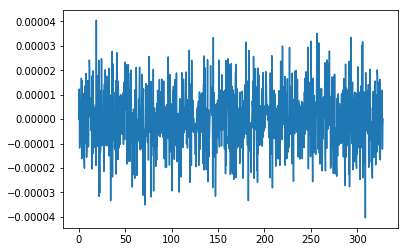

In [77]:
zplot = np.linspace(0, Lz, 1000)
plt.plot(zplot, Bx0(zplot))

In [78]:
test = sc.sparse.csr_matrix(bsp.collocation_matrix(T1, p - 1, zplot, bc, normalize=True))

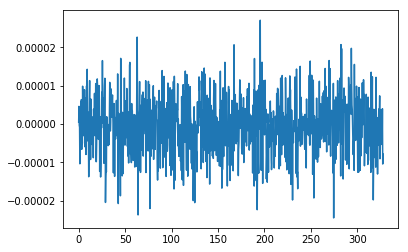

In [79]:
plt.plot(zplot, test.dot(bx))

In [20]:
energies

array([0.00000000e+00, 2.11834359e-09, 0.00000000e+00, 6.48859375e+00])

In [64]:
modes     = np.linspace(0, Nel, Nel + 1) - Nel/2
modes     = np.delete(modes, int(Nel/2))

(array([1.000000e+00, 2.300000e+01, 9.000000e+01, 4.850000e+02,
        2.075000e+03, 7.898000e+03, 2.564000e+04, 7.281300e+04,
        1.797750e+05, 3.892680e+05, 7.323280e+05, 1.192084e+06,
        1.693740e+06, 2.084941e+06, 2.237623e+06, 2.086752e+06,
        1.689358e+06, 1.195367e+06, 7.309720e+05, 3.893180e+05,
        1.809070e+05, 7.266500e+04, 2.547800e+04, 7.776000e+03,
        2.042000e+03, 4.650000e+02, 9.300000e+01, 1.800000e+01,
        4.000000e+00]),
 array([-3.        , -2.79310345, -2.5862069 , -2.37931034, -2.17241379,
        -1.96551724, -1.75862069, -1.55172414, -1.34482759, -1.13793103,
        -0.93103448, -0.72413793, -0.51724138, -0.31034483, -0.10344828,
         0.10344828,  0.31034483,  0.51724138,  0.72413793,  0.93103448,
         1.13793103,  1.34482759,  1.55172414,  1.75862069,  1.96551724,
         2.17241379,  2.37931034,  2.5862069 ,  2.79310345,  3.        ]),
 <a list of 29 Patch objects>)

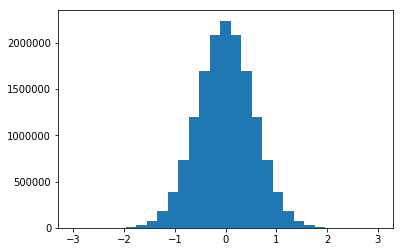

In [2]:
plt.hist(particles[:, 1], bins=np.linspace(-3, 3, 30))

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.4000e+01, 7.0400e+02, 8.3360e+03, 3.6328e+04, 5.9216e+04,
        3.6328e+04, 8.3360e+03, 7.0400e+02, 2.4000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-3.        , -2.79310345, -2.5862069 , -2.37931034, -2.17241379,
        -1.96551724, -1.75862069, -1.55172414, -1.34482759, -1.13793103,
        -0.93103448, -0.72413793, -0.51724138, -0.31034483, -0.10344828,
         0.10344828,  0.31034483,  0.51724138,  0.72413793,  0.93103448,
         1.13793103,  1.34482759,  1.55172414,  1.75862069,  1.96551724,
         2.17241379,  2.37931034,  2.5862069 ,  2.79310345,  3.        ]),
 <a list of 29 Patch objects>)

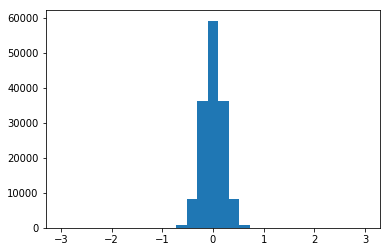

In [18]:
plt.hist(particles[:, 3], bins=np.linspace(-3, 3, 30))

In [8]:
import numpy as np

degree = 3
test = np.empty((degree,), dtype=float)

In [9]:
test.shape

(3,)

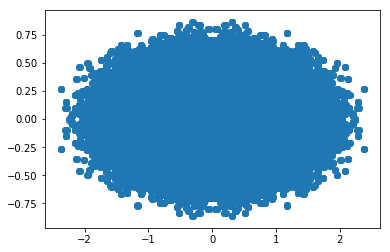

In [5]:
plt.scatter(particles[:, 2], particles[:, 3])

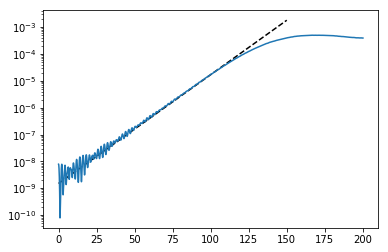

In [6]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

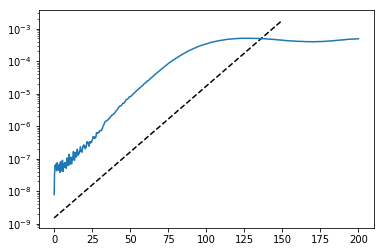

In [2]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_pseudorandom_5e5.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

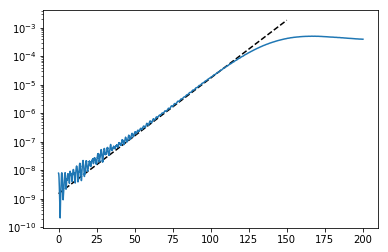

In [10]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_5e5_antithetic_skip=1000.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

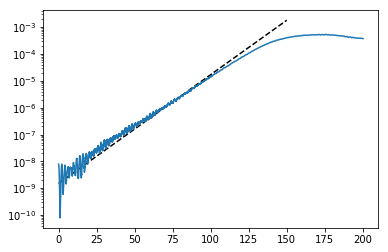

In [54]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_2e5_antitheticselalib_skip=1000_leap=0.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

In [103]:
en_B

array([7.85394892e-09, 7.77750909e-09, 7.58200013e-09, ...,
       4.61005279e-04, 4.60726824e-04, 4.60466108e-04])

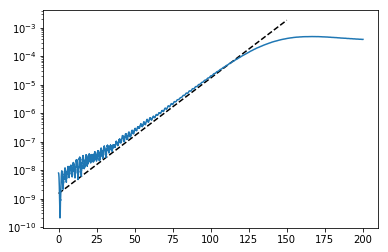

In [12]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_5e5_standard_skip=0.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

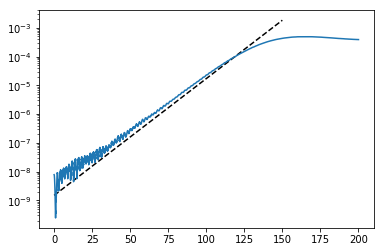

In [11]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_5e5_standard_skip=1000.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

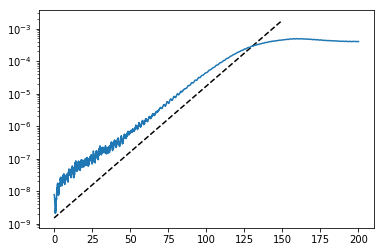

In [13]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_standard_skip=0.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

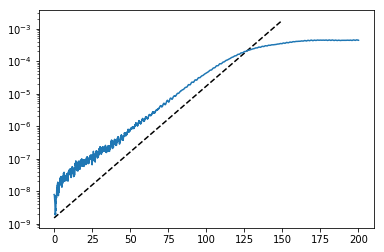

In [14]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_standard_skip=1000.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

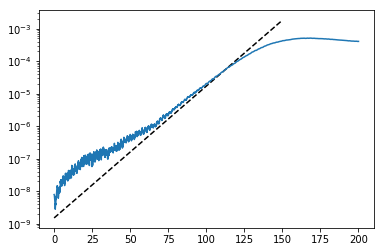

In [15]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_standard_skip=100000.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 1.5e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

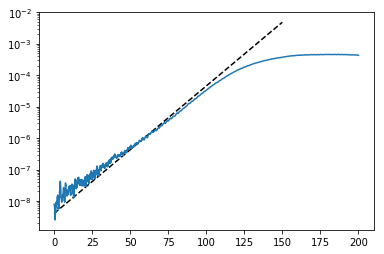

In [22]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_antithetic_skip=0.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 4e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

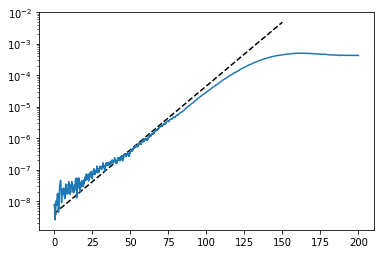

In [23]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_antithetic_skip=1000.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 4e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

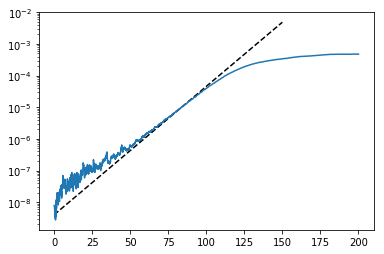

In [2]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_sobol_1e5_antithetic2_skip=2e16.txt')

tn   = test[:, -1]
en_B = test[:, -4]

freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
plt.semilogy(tn[:3000], 4e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

In [3]:
import numpy as np

In [4]:
import sobol_seq as sobol

In [7]:
test1 = sobol.i4_sobol_generate(4, 20)

In [8]:
test2 = 1 - sobol.i4_sobol_generate(4, 20)

In [9]:
test1[:, 0] + test2[:, 0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [11]:
import scipy.special as sp

In [13]:
sp.erfinv(2*test1[:, 1] - 1)

array([ 0.        , -0.47693628,  0.47693628, -0.22531206,  0.81341985,
       -0.81341985,  0.22531206, -0.34561711,  0.62730735, -1.08478704,
        0.11123545, -0.62730735,  0.34561711, -0.11123545,  1.08478704,
       -0.05544595,  1.31715033, -0.54901309,  0.40950828, -0.93197444])

In [14]:
sp.erfinv(2*test2[:, 1] - 1)

array([ 0.        ,  0.47693628, -0.47693628,  0.22531206, -0.81341985,
        0.81341985, -0.22531206,  0.34561711, -0.62730735,  1.08478704,
       -0.11123545,  0.62730735, -0.34561711,  0.11123545, -1.08478704,
        0.05544595, -1.31715033,  0.54901309, -0.40950828,  0.93197444])

In [15]:
test1[::3]

array([[0.5    , 0.5    , 0.5    , 0.5    ],
       [0.375  , 0.375  , 0.625  , 0.125  ],
       [0.125  , 0.625  , 0.875  , 0.875  ],
       [0.9375 , 0.0625 , 0.5625 , 0.9375 ],
       [0.8125 , 0.6875 , 0.4375 , 0.0625 ],
       [0.09375, 0.46875, 0.84375, 0.40625],
       [0.34375, 0.71875, 0.59375, 0.65625]])

In [16]:
test1

array([[0.5    , 0.5    , 0.5    , 0.5    ],
       [0.75   , 0.25   , 0.75   , 0.25   ],
       [0.25   , 0.75   , 0.25   , 0.75   ],
       [0.375  , 0.375  , 0.625  , 0.125  ],
       [0.875  , 0.875  , 0.125  , 0.625  ],
       [0.625  , 0.125  , 0.375  , 0.375  ],
       [0.125  , 0.625  , 0.875  , 0.875  ],
       [0.1875 , 0.3125 , 0.3125 , 0.6875 ],
       [0.6875 , 0.8125 , 0.8125 , 0.1875 ],
       [0.9375 , 0.0625 , 0.5625 , 0.9375 ],
       [0.4375 , 0.5625 , 0.0625 , 0.4375 ],
       [0.3125 , 0.1875 , 0.9375 , 0.5625 ],
       [0.8125 , 0.6875 , 0.4375 , 0.0625 ],
       [0.5625 , 0.4375 , 0.1875 , 0.8125 ],
       [0.0625 , 0.9375 , 0.6875 , 0.3125 ],
       [0.09375, 0.46875, 0.84375, 0.40625],
       [0.59375, 0.96875, 0.34375, 0.90625],
       [0.84375, 0.21875, 0.09375, 0.15625],
       [0.34375, 0.71875, 0.59375, 0.65625],
       [0.46875, 0.09375, 0.46875, 0.28125]])

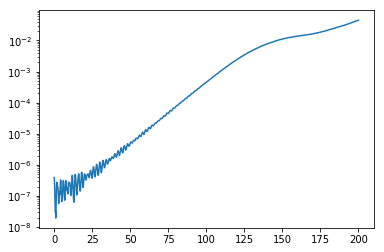

In [2]:
import numpy as np
import HyCho_FEM as fem
import matplotlib.pyplot as plt


test = np.loadtxt('results/test_2k.txt')

tn   = test[:, -1]
en_B = test[:, -4]

#freq = fem.solveDispersionHybrid(2., +1, 1., -1., 2., 0.2, 0.53, 6e-2, 0.5 + 0j, 1e-6, max_it=100)[0]
#plt.semilogy(tn[:3000], 4e-9*np.exp(2*tn[:3000]*np.imag(freq)), 'k--')


plt.semilogy(tn, en_B)

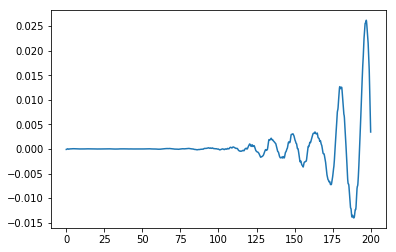

In [4]:
sig = np.fft.fft(test[:, :258])

In [5]:
test.shape

(4001, 262)

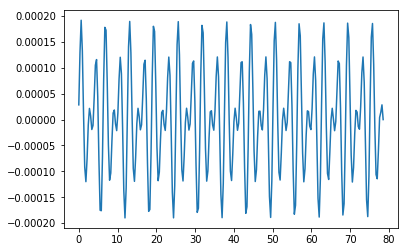

In [14]:
plt.plot(np.linspace(0., np.pi*25, 258), test[0, :258])

In [33]:
Nbins = 100
dbin  = Lz/Nbins

bins  = np.linspace(0., Lz, Nbins + 1)
test  = np.digitize(particles[:, 0], bins) - 1
nh    = np.zeros(Nbins)

In [34]:
for i in range(Nbins):
    nh[i] = sum(particles[test == i, 4])/(Np*dbin)

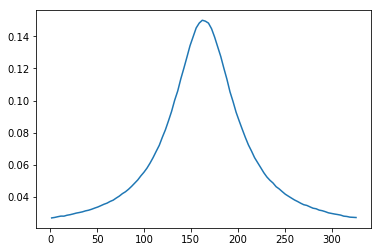

In [35]:
plt.plot(bins[:-1] + bins[1]/2, nh)

In [32]:
nuh*wpe**2

0.15